# Content Based Recommendation System (Recommending similar posts for given post)

## Our Goal

Preprocess the data to get the necessary features from the data, pipe it to our Recommender System. Conduct Data Analysis and see how similar the recommended Items are to the original.

We'll be doing two things:
- Bag of Words
- TFIDF

These are both **Text-based** Recommendations, where we will analyze characteristics of the data and the features of the texts and title of items to recommend new items(similar to Content-Based Filtering).

### Resolving Imports

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import matplotlib.pylab as plt
import scipy.sparse as sparse

import warnings
warnings.filterwarnings("ignore")

### Loading in Data, make sure to change the file paths!

In [2]:
df_posts = pd.read_csv('posts.csv') #what should the file paths be after you upload them
df_users = pd.read_csv('users.csv')
df_views = pd.read_csv('views.csv')
print(df_posts.head())
print(df_users.head())
print(df_views.head())

                        _id                          title  \
0  5d62abaa65218653a132c956                    hello there   
1  5d6d39567fa40e1417a4931c                      Ml and AI   
2  5d7d23315720533e15c3b1ee  What is an Operating System ?   
3  5d7d405e5720533e15c3b1f3                     Lord Shiva   
4  5d80dfbc6c53455f896e600e   How Competition law evolved?   

                                            category  post_type  
0                                Plant Biotechnology       blog  
1  Artificial Intelligence|Machine Learning|Infor...       blog  
2                                  Operating Systems       blog  
3                                           Drawings    artwork  
4                                   Competition Laws       blog  
                        _id                  name gender      academics
0  5d60098a653a331687083238  Nivesh Singh Chauhan   male  undergraduate
1  5d610ae1653a331687083239         Gaurav Sharma   male       graduate
2  5d618359fc5f

Here we are doing some slight feature engineering to make it useful for us to rename the columns as _id into post_id or user_id depending on the Data Frame.

In [3]:
df_posts.rename(columns={'_id': 'post_id', ' post_type': 'post_type'}, inplace=True)
df_users.rename(columns={'_id': 'user_id'}, inplace=True)
df_posts.category = df_posts.category.fillna('')
print(df_posts.head())
print(df_users.head())

                    post_id                          title  \
0  5d62abaa65218653a132c956                    hello there   
1  5d6d39567fa40e1417a4931c                      Ml and AI   
2  5d7d23315720533e15c3b1ee  What is an Operating System ?   
3  5d7d405e5720533e15c3b1f3                     Lord Shiva   
4  5d80dfbc6c53455f896e600e   How Competition law evolved?   

                                            category post_type  
0                                Plant Biotechnology      blog  
1  Artificial Intelligence|Machine Learning|Infor...      blog  
2                                  Operating Systems      blog  
3                                           Drawings   artwork  
4                                   Competition Laws      blog  
                    user_id                  name gender      academics
0  5d60098a653a331687083238  Nivesh Singh Chauhan   male  undergraduate
1  5d610ae1653a331687083239         Gaurav Sharma   male       graduate
2  5d618359fc5fcf3bdd

In [4]:
# merging users table with views using user id as key
df_merged = pd.merge(df_views, df_users, on='user_id')
# merging posts table with newly created merged table using post id as key
df_merged = pd.merge(df_merged, df_posts, on='post_id')
df_merged.head()

,user_id,post_id,timestamp,name,gender,academics,title,category,post_type
0,5df49b32cc709107827fb3c7,5ec821ddec493f4a2655889e,2020-06-01T10:46:45.131Z,Niriksha Sharma,female,undergraduate,Save Earth.,Visual Arts|Graphic Design|Artistic design|Gra...,artwork
1,5d7c994d5720533e15c3b1e9,5ec821ddec493f4a2655889e,2020-05-22T20:11:32.317Z,Varun Chowhan,male,undergraduate,Save Earth.,Visual Arts|Graphic Design|Artistic design|Gra...,artwork
2,5e5af599d701ab08af792b63,5ec821ddec493f4a2655889e,2020-05-22T20:01:37.309Z,Ilupeju Ayokunnumi,female,graduate,Save Earth.,Visual Arts|Graphic Design|Artistic design|Gra...,artwork
3,5de50d768eab6401affbb135,5ec821ddec493f4a2655889e,2020-05-22T20:10:41.100Z,thesocialcomment,male,graduate,Save Earth.,Visual Arts|Graphic Design|Artistic design|Gra...,artwork
4,5deeef6142a8854bf6eabab9,5ec821ddec493f4a2655889e,2020-05-22T20:08:45.061Z,siddharth saxena,male,undergraduate,Save Earth.,Visual Arts|Graphic Design|Artistic design|Gra...,artwork


In [5]:
df_merged.drop(columns='timestamp', inplace=True)
df_merged.head()

,user_id,post_id,name,gender,academics,title,category,post_type
0,5df49b32cc709107827fb3c7,5ec821ddec493f4a2655889e,Niriksha Sharma,female,undergraduate,Save Earth.,Visual Arts|Graphic Design|Artistic design|Gra...,artwork
1,5d7c994d5720533e15c3b1e9,5ec821ddec493f4a2655889e,Varun Chowhan,male,undergraduate,Save Earth.,Visual Arts|Graphic Design|Artistic design|Gra...,artwork
2,5e5af599d701ab08af792b63,5ec821ddec493f4a2655889e,Ilupeju Ayokunnumi,female,graduate,Save Earth.,Visual Arts|Graphic Design|Artistic design|Gra...,artwork
3,5de50d768eab6401affbb135,5ec821ddec493f4a2655889e,thesocialcomment,male,graduate,Save Earth.,Visual Arts|Graphic Design|Artistic design|Gra...,artwork
4,5deeef6142a8854bf6eabab9,5ec821ddec493f4a2655889e,siddharth saxena,male,undergraduate,Save Earth.,Visual Arts|Graphic Design|Artistic design|Gra...,artwork


In [6]:
print(f"Dataframe shape {df_merged.shape}")
print(f"Dataframe columns {set(df_merged.columns)}")

Dataframe shape (1447, 8)
Dataframe columns {'category', 'name', 'academics', 'title', 'user_id', 'post_id', 'post_type', 'gender'}


# Text Representation!

Below are some conceptual examples of how we can go about setting up TFIDF(we didn't explore Bag of Words in our Representation).

## Bag of Words (BoW) Representation

Bag of Words is a simple and intuitive method for representing text data, where each document is represented as a bag (unordered set) of words, disregarding grammar and word order. The basic steps involved in creating a Bag of Words representation are:

1. **Tokenization:** Splitting the text into individual words or tokens.
2. **Vocabulary Construction:** Creating a vocabulary of unique words present in the corpus (collection of documents).
3. **Counting:** Counting the frequency of each word in the vocabulary within each document.
4. **Vectorization:** Representing each document as a numerical vector, where each dimension corresponds to a word in the vocabulary, and the value of each dimension represents the frequency of the corresponding word in the document.

For example, consider the following two sentences:

- Sentence 1: "The cat sat on the mat."
- Sentence 2: "The dog played in the yard."

The Bag of Words representation for these sentences might look like this:

|        | The | cat | sat | on | mat | dog | played | in | yard |
|--------|-----|-----|-----|----|-----|-----|--------|----|------|
| Sentence 1 | 1   | 1   | 1   | 1  | 1   | 0   | 0      | 0  | 0    |
| Sentence 2 | 1   | 0   | 0   | 0  | 0   | 1   | 1      | 1  | 1    |

Each row in the table represents a document (sentence), and each column represents a word in the vocabulary. The numbers in the table indicate the frequency of each word in the corresponding document.


## TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF is a numerical statistic that reflects the importance of a word in a document relative to a collection of documents (corpus). It combines two components:

1. **Term Frequency (TF):** Measures the frequency of a term (word) in a document. It is calculated as the ratio of the number of times a term appears in a document to the total number of terms in the document.

   `TF(t, d) = (Number of occurrences of term t in document d) / (Total number of terms in document d)`

2. **Inverse Document Frequency (IDF):** Measures the rarity of a term across documents in the corpus. It is calculated as the logarithm of the ratio of the total number of documents in the corpus to the number of documents containing the term \( t \).

   `IDF(t, D) = log(Total number of documents in corpus D / Number of documents containing term t)`

The TF-IDF score for a term in a document is then calculated by multiplying its TF and IDF values:

`TF-IDF(t, d, D) = TF(t, d) × IDF(t, D)`

The TF-IDF score increases proportionally to the number of times a term appears in a document (TF) and decreases logarithmically with the frequency of the term across documents (IDF).

TF-IDF is beneficial because it not only considers the frequency of a term in a document but also evaluates the significance of the term in the context of the entire corpus. It helps in identifying important words that are specific to certain documents while being rare in others.

In [7]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')

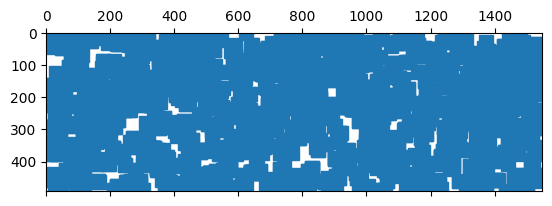

In [8]:
tf_matrix1 = tf.fit_transform(df_posts['title'])
plt.spy(tf_matrix1)

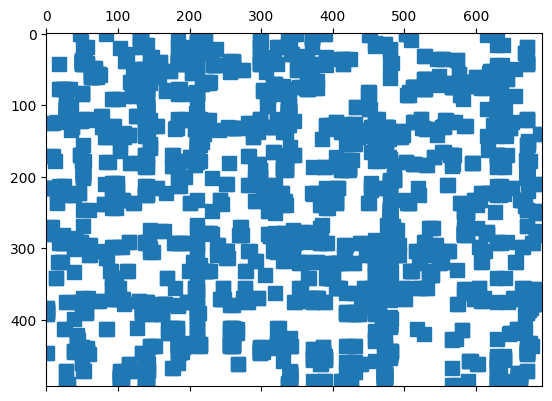

In [9]:
tf_matrix2 = tf.fit_transform(df_posts['category'])
plt.spy(tf_matrix2)

In [10]:
# tf_matrix3 = tf.fit_transform(df_posts['post_type'])
# plt.spy(tf_matrix3)

In [11]:
# establishing relation between posts using post title, category and type
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tf_matrix1 = tf.fit_transform(df_posts['title'])
tf_matrix2 = tf.fit_transform(df_posts['category'])
# tf_matrix3 = tf.fit_transform(df_posts['post_type'])

csm1 = linear_kernel(tf_matrix1, tf_matrix1)
csm2 = linear_kernel(tf_matrix2, tf_matrix2)
# csm3 = linear_kernel(tf_matrix3, tf_matrix3)
csm_tf = (csm1 + csm2)/3

In [12]:
csm_tf.shape

(493, 493)

In [13]:
def cleanData(x):
    if isinstance(x, list):
        return str.lower(x)
    else:
        if isinstance(x, str):
            return str.lower(x)
        else:
            return ''

def combine(x):
    # new columns for algo application and to prevent affecting the original data
    return x['title1'] + ' ' + x['category1']

features = ['title', 'category']

for feature in features:
    df_posts[feature + '1'] = df_posts[feature].apply(cleanData)

df_posts['merged'] = df_posts.apply(combine, axis=1)
# df_posts.head()

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_posts['merged'])
csm_count = cosine_similarity(count_matrix, count_matrix)
# delete the new columns as processing is done on the merged column
df_posts.drop(columns=['title1', 'category1', 'merged'], inplace=True)
df_posts.drop(columns='post_id', inplace=True)

In [14]:
# recommmendation function
indices = pd.Series(df_posts.index, index=df_posts.title)

# first we pass csm in the function definition without giving any value. Later, when the function is called, it will be checked for different values of csm for which the function gives the best results.
# That value of csm will then be passed in the function definition, so that csm value isn't needed to be given while calling the function.

# earlier
# def recommend(post, csm):
# later
def recommend(post, csm=(csm_tf + csm_count)/2):        # choosing this csm as it covers both aspects
    idx = indices[post]
    score_series = list(enumerate(csm[idx]))
    score_series = sorted(score_series, key=lambda x: x[1], reverse=True)
    score_series = score_series[1:11]   # not recommending the original post itself, starting from 1
    post_indices = [i[0] for i in score_series]
    return df_posts.loc[post_indices].style.hide_index()

In [15]:
print(csm_tf)
print(csm_count)
print((csm_tf + csm_count)/2)

[[0.66666667 0.         0.         ... 0.         0.         0.        ]
 [0.         0.66666667 0.         ... 0.         0.0230504  0.0759607 ]
 [0.         0.         0.66666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.33333333 0.         0.        ]
 [0.         0.0230504  0.         ... 0.         0.66666667 0.05353237]
 [0.         0.0759607  0.         ... 0.         0.05353237 0.66666667]]
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.26726124 0.25      ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.26726124 0.         ... 0.         1.         0.17817416]
 [0.         0.25       0.         ... 0.         0.17817416 1.        ]]
[[0.83333333 0.         0.         ... 0.         0.         0.        ]
 [0.         0.83333333 0.         ... 

### Final recommendation

In [16]:
recommend('10 Best Artificial Intelligence (AI) Courses Online for 2020')

title,category,post_type
7 Best Python Data Science Courses & Certification [2020],Computer Technology|Machine Learning,blog
Learning...,Computer Technology|Machine Learning,blog
GAN's Part(2),Computer Technology|Machine Learning,blog
"Machine Learning”&“Operations"" (MlOps)",Computer Technology|Machine Learning,blog
Recommend Systems Machine Learning,Computer Technology|Machine Learning,blog
8 Best Machine Learning Courses for 2020,Computer Technology|Cloud Computing|Artificial Intelligence|Information Technology|Programming languages,blog
GAN's INTRODUCTION,Computer Technology|Machine Learning,blog
Ml and AI,Artificial Intelligence|Machine Learning|Information Technology,blog
Artificial Intelligence,Computer Technology|Artificial Intelligence,blog
Types Of AI.,Computer Technology|Artificial Intelligence,blog


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())

print(X.shape)

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
(4, 9)


In [20]:
vectorizer

TfidfVectorizer()

In [21]:
X

<4x9 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

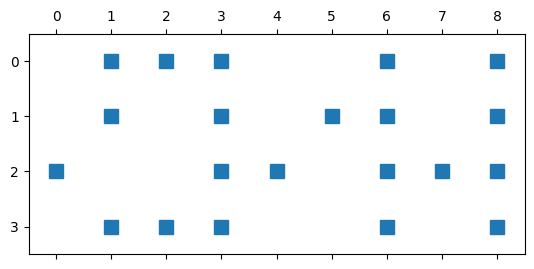

In [22]:
import matplotlib.pylab as plt
import scipy.sparse as sparse
plt.spy(X)